The goal of this notebook is to predict GDP in general.
I'm training models on all data instead of splitting into training and test because the end goal is to predict the future.

Testing:
- With and without Year label
- For all values versus predicting in the new year, 2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_eurostat = pd.read_csv("https://raw.githubusercontent.com/SDuncan5/Eurostat-Data/main/eurostat_pcap_no_nans.csv")
df_eurostat = df_eurostat.drop(columns=["Unnamed: 0"])
df_eurostat

,geo,Year,CPI,Immigrants,Population,Housing Index,GDP,emigration,unemployment,total_deaths,Exports,Imports,Immigrants_pcap,GDP_pcap,Emigrants_pcap,Deaths_pcap,Exports_pcap,Imports_pcap
0,Austria,2011,93.35,82230.0,8391643.0,81.60,310128.7,51197.0,3.3,76479.0,127462.4,137512.5,0.009799,36956.851000,0.006101,0.009114,0.015189,0.016387
1,Austria,2012,95.75,91557.0,8429991.0,87.57,318653.0,51812.0,3.5,79436.0,129678.5,138942.4,0.010861,37799.921732,0.006146,0.009423,0.015383,0.016482
2,Austria,2013,97.77,101866.0,8479823.0,92.10,323910.2,54071.0,3.8,79526.0,131884.6,137999.8,0.012013,38197.754835,0.006376,0.009378,0.015553,0.016274
3,Austria,2014,99.20,116262.0,8546356.0,95.33,333146.1,53491.0,4.0,78252.0,134172.5,137001.2,0.013604,38981.069827,0.006259,0.009156,0.015699,0.016030
4,Austria,2015,100.00,166323.0,8642699.0,100.00,344269.2,56689.0,4.1,83073.0,137756.8,140699.2,0.019244,39833.528855,0.006559,0.009612,0.015939,0.016280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,Slovakia,2017,100.90,7188.0,5439232.0,112.99,84669.9,3466.0,5.4,53914.0,73790.1,72191.9,0.001322,15566.517479,0.000637,0.009912,0.013566,0.013272
281,Slovakia,2018,103.46,7253.0,5446771.0,121.32,89874.7,3298.0,4.3,54293.0,79136.9,78727.4,0.001332,16500.546838,0.000605,0.009968,0.014529,0.014454
282,Slovakia,2019,106.33,7016.0,5454147.0,132.39,94429.7,3384.0,3.8,53234.0,79962.0,80407.4,0.001286,17313.376409,0.000620,0.009760,0.014661,0.014742
283,Slovakia,2020,108.47,6775.0,5458827.0,145.06,93444.1,2428.0,4.4,59089.0,75586.2,73700.2,0.001241,17117.981574,0.000445,0.010824,0.013847,0.013501


In [10]:
# not per_capita data
X_reg = df_eurostat[["geo", "Year", "CPI", "Immigrants", "Population", "Housing Index", "emigration", "unemployment", "total_deaths", "Exports", "Imports"]]
X_cap = df_eurostat[["geo", "Year", "CPI", "Immigrants_pcap", "Population", "Housing Index", "Emigrants_pcap", "unemployment", "Deaths_pcap", "Exports_pcap", "Imports_pcap"]]
gdp = df_eurostat["GDP"]
gdp_cap = df_eurostat["GDP_pcap"]

# KNN - General

## Feature Selection

In [20]:
from itertools import chain, combinations

def powerset(iterable):
    features = list(iterable)
    return chain.from_iterable(combinations(features, r) for r in range(len(features)+1))

reg_features = ["geo", "Year", "CPI", "Immigrants", "Population", "Housing Index", "emigration", "unemployment", "total_deaths", "Exports", "Imports"]

# Creating a power set of all possible regular features to test for the best model
reg_power_set = []
for subset in powerset(reg_features):
    reg_power_set.append(list(subset))

# First value is empty, so remove
reg_power_set = reg_power_set[1:]
len(reg_power_set)
# That's a lot of combinations

2047

In [21]:
# Takes ~5 min to run

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

# define function to calculate estimate of test error for a given feature set
def get_cv_error(features):

  quant_vars = []
  cat_vars = []
  for feature in features:
    if X_reg.dtypes[feature] == "int64" or  X_reg.dtypes[feature] == "float64":
      quant_vars.append(feature)
    else:
      cat_vars.append(feature)

  ct = make_column_transformer(
      (StandardScaler(), quant_vars),
      (OneHotEncoder(handle_unknown="ignore"), cat_vars),
      remainder="drop"
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=5)
  )
  # errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_reg[features],
                             y=gdp,
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

  ["geo", "Year", "CPI", "Immigrants", "Population", "Housing Index", "emigration", "unemployment", "total_deaths", "Exports", "Imports"]

# calculate and store errors for different feature sets
errs = pd.Series()
for features in reg_power_set:
  errs[str(features)] = get_cv_error(features)

errs

<ipython-input-21-6638aa4ed671>:38: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  errs = pd.Series()


['geo']                                                                                                                                    1.734278e+11
['Year']                                                                                                                                   7.050848e+11
['CPI']                                                                                                                                    7.353740e+11
['Immigrants']                                                                                                                             1.334403e+11
['Population']                                                                                                                             9.331704e+10
                                                                                                                                               ...     
['geo', 'Year', 'CPI', 'Population', 'Housing Index', 'emigration', 'unemployment', 'tot

In [23]:
errs.sort_values()

['geo', 'Year', 'Population', 'Imports']                             3.808488e+10
['geo', 'Year', 'CPI', 'Population', 'Imports']                      3.928704e+10
['geo', 'Year', 'Immigrants', 'Population', 'Imports']               4.095578e+10
['geo', 'Year', 'Immigrants', 'Population', 'Exports', 'Imports']    4.100335e+10
['geo', 'Year', 'CPI', 'Population', 'Exports', 'Imports']           4.312268e+10
                                                                         ...     
['Year', 'Housing Index']                                            7.774358e+11
['Year', 'CPI', 'Housing Index']                                     7.798444e+11
['Housing Index', 'unemployment']                                    8.081463e+11
['CPI', 'Housing Index']                                             8.128890e+11
['unemployment']                                                     8.393198e+11
Length: 2047, dtype: float64

The features with lowest MSE are:
- ['geo', 'Year', 'Population', 'Imports']
- ['geo', 'Year', 'CPI', 'Population', 'Imports']
- ['geo', 'Year', 'Immigrants', 'Population', 'Imports']
- ['geo', 'Year', 'Immigrants', 'Population', 'Exports', 'Imports']

## K Selection

In [25]:
ct = make_column_transformer(
    (StandardScaler(), ['Year', 'Population', 'Imports']),
    (OneHotEncoder(handle_unknown="ignore"), ['geo']),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=5)
)

In [26]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_squared_error",
                           cv=10)
grid_search.fit(X_reg[['geo', 'Year', 'Population', 'Imports']], gdp)
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Year', 'Population',
                                                   'Imports']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geo'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=8))])

<Axes: title={'center': 'kNN models with 4 features'}, xlabel='k', ylabel='test error'>

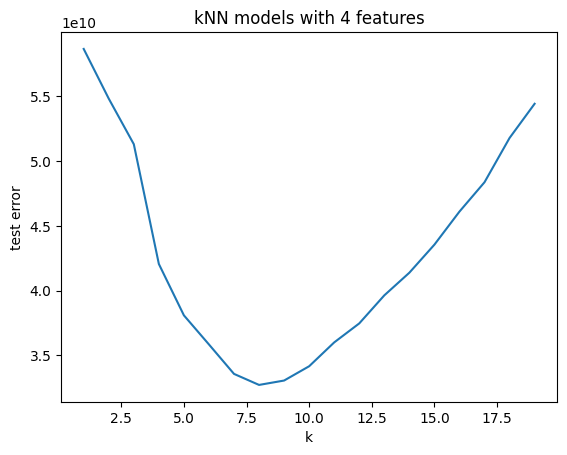

In [27]:
df_cv_results_ = pd.DataFrame(grid_search.cv_results_)
df_cv_results_["param_kneighborsregressor__n_neighbors"] = df_cv_results_["param_kneighborsregressor__n_neighbors"].astype(int)
df_cv_results_.set_index("param_kneighborsregressor__n_neighbors", inplace = True)
(-df_cv_results_["mean_test_score"]).plot.line(xlabel = "k", ylabel = "test error", title = "kNN models with 4 features")

The best number of neighbors = 8

## Testing Out the Model
K = 8 <br>
Features = ['geo', 'Year', 'Population', 'Imports']

In [33]:
from sklearn.model_selection import train_test_split

X_knn1 = X_reg[["geo", "Year", "Population", "Imports"]]
# y = gdp

# split into test and training
X_knn1_train, X_knn1_test, y_knn1_train, y_knn1_test = train_test_split(X_knn1, gdp, test_size=0.25, random_state=0)

In [34]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

ct = make_column_transformer(
    (StandardScaler(), ['Year', 'Population', 'Imports']),
    (OneHotEncoder(handle_unknown="ignore"), ['geo']),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=8)
)

In [36]:
pipeline.fit(X_knn1_train, y_knn1_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Year', 'Population',
                                                   'Imports']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geo'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=8))])

In [ ]:
# cross validation scoring

In [42]:
scores = -cross_val_score(pipeline,
                         X_knn1_train,
                         y_knn1_train,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

101692.2143834381

In [ ]:
# test scoring

In [38]:
print("Train Score : ", pipeline.score(X_knn1_train, y_knn1_train)," Test Score : ", pipeline.score(X_knn1_test, y_knn1_test))

Train Score :  0.9850626807972832  Test Score :  0.9789798238844324


In [39]:
y_knn1_pred = pipeline.predict(X_knn1_test)

RMSE

In [40]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_knn1_test, y_knn1_pred))
rmse

124842.11379156707

Benchmark

In [83]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_knn1_train, y=y_knn1_train, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

690927.3333981774

In [45]:
y_knn1_test.std()

867121.6148310832

Based on these benchmarks, I'd say our model did a much better job!

R^2

In [43]:
r_squared = 1 - (((y_knn1_test - y_knn1_pred)**2).mean()) / ((y_knn1_test - y_knn1_pred.mean())**2).mean()
r_squared

0.9789898570610891

That's a really good R^2 value.
97.9% of the variability in GDP is explained by this model.

# KNN - Predicting for 2021
Removing 2021 from the dataset and seeing how the model performs for an unknown year

In [234]:
# train
no_2021 = df_eurostat[["geo", "Year", "Population", "Imports", "GDP"]]
no_2021 = no_2021[no_2021["Year"] != 2021]
X_knn_no_2021 = no_2021.drop(columns=["GDP"])
gdp_no_2021 = no_2021["GDP"]


# remove all instances of 2021 (test)
yes_2021 = df_eurostat[["geo", "Year", "Population", "Imports", "GDP"]]
yes_2021 = yes_2021[yes_2021["Year"] == 2021]
X_knn_yes_2021 = yes_2021.drop(columns=["GDP"])
gdp_yes_2021 = yes_2021["GDP"]

In [235]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

ct = make_column_transformer(
    (StandardScaler(), ['Year', 'Population', 'Imports']),
    (OneHotEncoder(handle_unknown="ignore"), ['geo']),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=8)
)

In [236]:
pipeline.fit(X_knn_no_2021, gdp_no_2021)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Year', 'Population',
                                                   'Imports']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geo'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=8))])

In [237]:
# cross validation scoring

In [238]:
scores = -cross_val_score(pipeline,
                         X_knn_no_2021,
                         gdp_no_2021,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

150882.37082297204

In [ ]:
# test scoring

In [70]:
print("Train Score : ", pipeline.score(X_knn_no_2021, gdp_no_2021)," Test Score : ", pipeline.score(X_knn_yes_2021, gdp_yes_2021))

Train Score :  0.993904443480282  Test Score :  0.9702751426053756


In [76]:
y_knn_2021_pred = pipeline.predict(X_knn_yes_2021)

RMSE

In [239]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(gdp_yes_2021, y_knn_2021_pred))
rmse

145482.641500312

Benchmark

In [240]:
gdp_yes_2021.std()

860533.8484067871

In [222]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_knn_no_2021, y=gdp_no_2021, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

659915.7065210016

Based on this benchmark, I'd say our model did a much better job!

R^2

In [81]:
r_squared = 1 - (((gdp_yes_2021 - y_knn_2021_pred)**2).mean()) / ((gdp_yes_2021 - y_knn_2021_pred.mean())**2).mean()
r_squared

0.970367428062654

That's a really good R^2 value.
97.0% of the variability in GDP is explained by this model.

# KNN - Comparing to Time Series

# Linear Regression - General

Should log transform variables.
As seen in the data visualization set, a lot of data is skewed.

In [84]:
X_reg

,geo,Year,CPI,Immigrants,Population,Housing Index,emigration,unemployment,total_deaths,Exports,Imports
0,Austria,2011,93.35,82230.0,8391643.0,81.60,51197.0,3.3,76479.0,127462.4,137512.5
1,Austria,2012,95.75,91557.0,8429991.0,87.57,51812.0,3.5,79436.0,129678.5,138942.4
2,Austria,2013,97.77,101866.0,8479823.0,92.10,54071.0,3.8,79526.0,131884.6,137999.8
3,Austria,2014,99.20,116262.0,8546356.0,95.33,53491.0,4.0,78252.0,134172.5,137001.2
4,Austria,2015,100.00,166323.0,8642699.0,100.00,56689.0,4.1,83073.0,137756.8,140699.2
...,...,...,...,...,...,...,...,...,...,...,...
280,Slovakia,2017,100.90,7188.0,5439232.0,112.99,3466.0,5.4,53914.0,73790.1,72191.9
281,Slovakia,2018,103.46,7253.0,5446771.0,121.32,3298.0,4.3,54293.0,79136.9,78727.4
282,Slovakia,2019,106.33,7016.0,5454147.0,132.39,3384.0,3.8,53234.0,79962.0,80407.4
283,Slovakia,2020,108.47,6775.0,5458827.0,145.06,2428.0,4.4,59089.0,75586.2,73700.2


## Log Transforming

<ipython-input-86-18e663455fd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reg["log(Immigrants)"] = np.log(X_reg["Immigrants"])


<Axes: title={'center': 'Log Immigrants Distribution'}, ylabel='Frequency'>

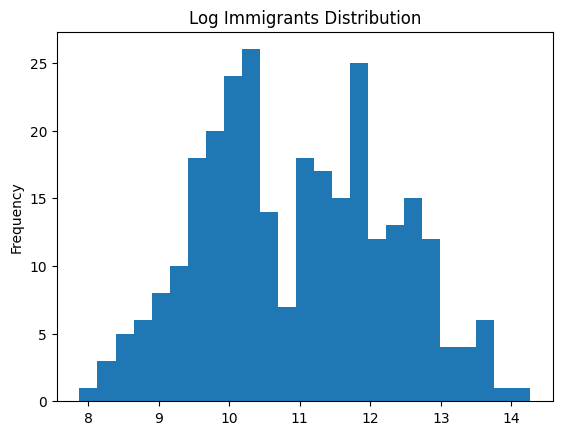

In [86]:
X_reg["log(Immigrants)"] = np.log(X_reg["Immigrants"])
X_reg["log(Immigrants)"].plot.hist(xlabel="Log Number of Immigrants", title="Log Immigrants Distribution", bins=25)

<ipython-input-107-bcce014eb10e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cap["log(Population)"] = np.log(X_cap["Population"])


<Axes: title={'center': 'Log Population Distribution'}, ylabel='Frequency'>

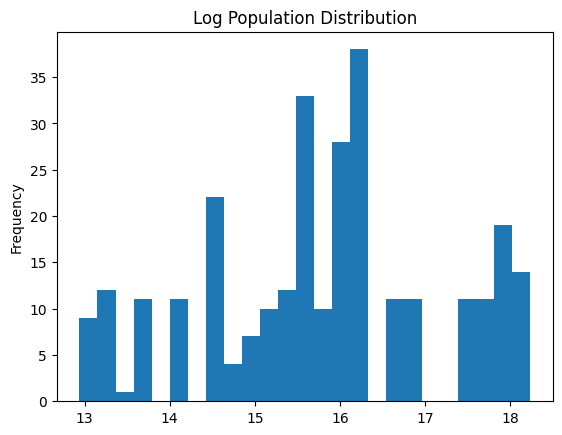

In [107]:
X_reg["log(Population)"] = np.log(X_reg["Population"])
X_cap["log(Population)"] = np.log(X_cap["Population"])

X_reg["log(Population)"].plot.hist(xlabel="Log Population", title="Log Population Distribution", bins=25)

<ipython-input-88-175ad1c3279c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reg["log(Emigrants)"] = np.log(X_reg["emigration"])


<Axes: title={'center': 'Log Emigrants Distribution'}, ylabel='Frequency'>

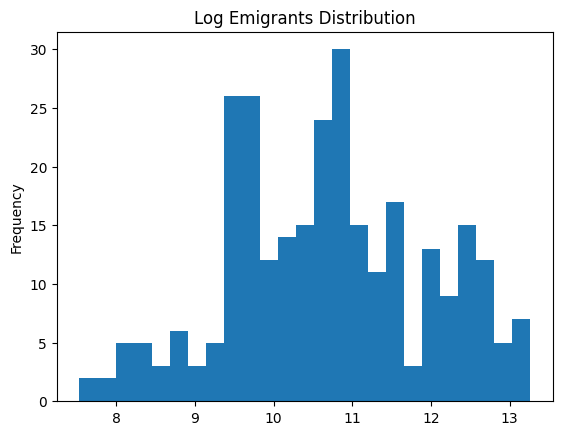

In [88]:
X_reg["log(Emigrants)"] = np.log(X_reg["emigration"])
X_reg["log(Emigrants)"].plot.hist(xlabel="Log Number of Emigrants", title="Log Emigrants Distribution", bins=25)

<ipython-input-90-fa317088e658>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reg["log(Unemployment)"] = np.log(X_reg["unemployment"])


<Axes: title={'center': 'Log Unemployment Rate Distribution'}, ylabel='Frequency'>

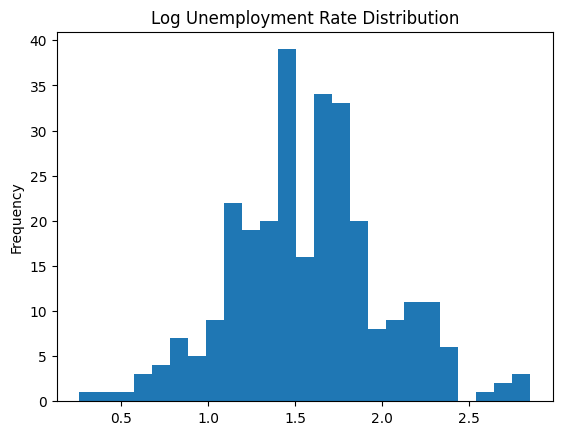

In [90]:
X_reg["log(Unemployment)"] = np.log(X_reg["unemployment"])
X_reg["log(Unemployment)"].plot.hist(xlabel="Log Unemployment Rate", title="Log Unemployment Rate Distribution", bins=25)

<ipython-input-91-95e86eccef03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reg["log(Deaths)"] = np.log(X_reg["total_deaths"])


<Axes: title={'center': 'Log Number of Deaths Distribution'}, ylabel='Frequency'>

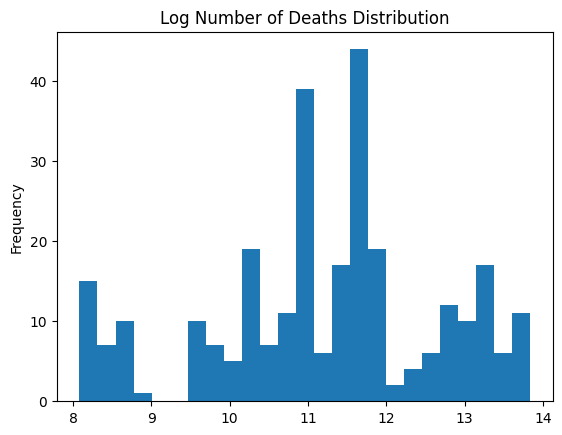

In [91]:
X_reg["log(Deaths)"] = np.log(X_reg["total_deaths"])
X_reg["log(Deaths)"].plot.hist(xlabel="Log Deaths", title="Log Number of Deaths Distribution", bins=25)

<ipython-input-92-884f1a1d6827>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reg["log(Exports)"] = np.log(X_reg["Exports"])


<Axes: title={'center': 'Log Exports Distribution'}, ylabel='Frequency'>

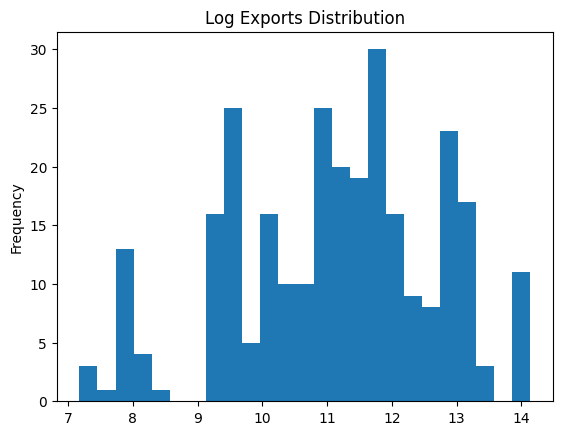

In [92]:
X_reg["log(Exports)"] = np.log(X_reg["Exports"])
X_reg["log(Exports)"].plot.hist(xlabel="Log Exports", title="Log Exports Distribution", bins=25)

<Axes: title={'center': 'Log Imports Distribution'}, ylabel='Frequency'>

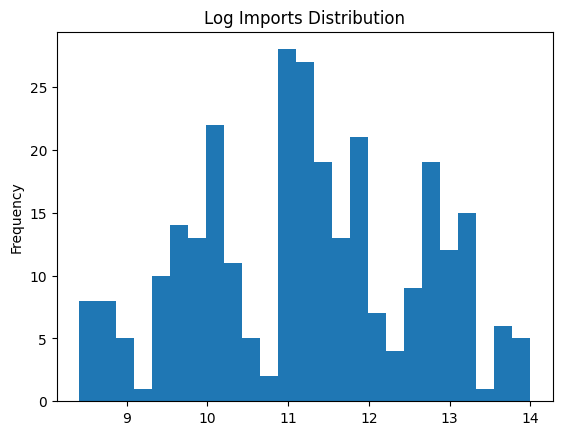

In [93]:
X_reg["log(Imports)"] = np.log(X_reg["Imports"])
X_reg["log(Imports)"].plot.hist(xlabel="Log Imports", title="Log Imports Distribution", bins=25)

<Axes: title={'center': 'Log GDP Distribution'}, ylabel='Frequency'>

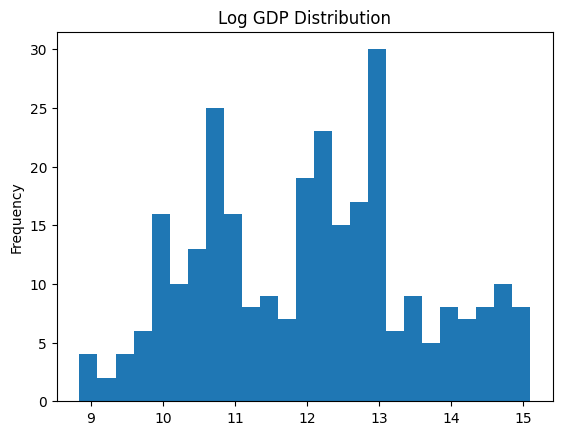

In [97]:
# also log transform GDP
log_gdp = np.log(gdp)
log_gdp.plot.hist(xlabel="Log GDP", title="Log GDP Distribution", bins=25)

## Feature Selection

In [101]:
from itertools import chain, combinations

def powerset(iterable):
    features = list(iterable)
    return chain.from_iterable(combinations(features, r) for r in range(len(features)+1))

reg_features = ["geo", "Year", "CPI", "log(Immigrants)", "log(Population)", "Housing Index", "log(Emigrants)", "log(Unemployment)", "log(Deaths)", "log(Exports)", "log(Imports)"]

# Creating a power set of all possible regular features to test for the best model
reg_power_set = []
for subset in powerset(reg_features):
    reg_power_set.append(list(subset))

# First value is empty, so remove
reg_power_set = reg_power_set[1:]
len(reg_power_set)
# That's a lot of combinations

2047

In [102]:
# Takes ~5 min to run

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

# define function to calculate estimate of test error for a given feature set
def get_cv_error(features):

  quant_vars = []
  cat_vars = []
  for feature in features:
    if X_reg.dtypes[feature] == "int64" or  X_reg.dtypes[feature] == "float64":
      quant_vars.append(feature)
    else:
      cat_vars.append(feature)

  ct = make_column_transformer(
      (StandardScaler(), quant_vars),
      (OneHotEncoder(handle_unknown="ignore"), cat_vars),
      remainder="drop"
  )

  pipeline = make_pipeline(
      ct,
      LinearRegression()
  )
  # errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_reg[features],
                             y=log_gdp,
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in reg_power_set:
  errs[str(features)] = get_cv_error(features)

errs

<ipython-input-102-7e9d91271b2d>:38: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  errs = pd.Series()


['geo']                                                                                                                                                                1.338080
['Year']                                                                                                                                                               2.444883
['CPI']                                                                                                                                                                2.440426
['log(Immigrants)']                                                                                                                                                    0.517105
['log(Population)']                                                                                                                                                    0.439551
                                                                                                                        

In [103]:
errs.sort_values()

['Year', 'CPI', 'log(Immigrants)', 'log(Population)', 'log(Unemployment)', 'log(Deaths)', 'log(Exports)']    0.102480
['Year', 'log(Immigrants)', 'log(Population)', 'log(Unemployment)', 'log(Deaths)', 'log(Exports)']           0.102568
['log(Immigrants)', 'log(Population)', 'log(Deaths)', 'log(Imports)']                                        0.102854
['Year', 'CPI', 'log(Immigrants)', 'log(Population)', 'log(Unemployment)', 'log(Deaths)', 'log(Imports)']    0.103289
['Year', 'CPI', 'log(Immigrants)', 'log(Population)', 'log(Deaths)', 'log(Imports)']                         0.103661
                                                                                                               ...   
['geo', 'log(Immigrants)', 'log(Population)', 'log(Emigrants)', 'log(Exports)']                              3.273926
['geo', 'log(Population)', 'log(Emigrants)', 'log(Deaths)', 'log(Exports)']                                  3.320444
['geo', 'log(Population)', 'log(Emigrants)', 'log(Export

## Testing Out the Model
Features = ['Year', 'CPI', 'log(Immigrants)', 'log(Population)', 'log(Unemployment)', 'log(Deaths)', 'log(Exports)']

In [241]:
from sklearn.model_selection import train_test_split

X_lin1 = X_reg[['Year', 'CPI', 'log(Immigrants)', 'log(Population)', 'log(Unemployment)', 'log(Deaths)', 'log(Exports)']]
# y = gdp

# split into test and training
X_lin1_train, X_lin1_test, y_lin1_train, y_lin1_test = train_test_split(X_lin1, log_gdp, test_size=0.25, random_state=0)

In [242]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

# ct = make_column_transformer(
#     (StandardScaler(), ['Year', 'Population', 'Imports']),
#     (OneHotEncoder(handle_unknown="ignore"), ['geo']),
#     remainder="drop"
# )

pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

In [243]:
pipeline.fit(X_lin1_train, y_lin1_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
# cross validation scoring

In [244]:
scores = -cross_val_score(pipeline,
                         X_lin1_train,
                         y_lin1_train,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

0.2752669104287434

In [ ]:
# test scoring

In [245]:
print("Train Score : ", pipeline.score(X_lin1_train, y_lin1_train)," Test Score : ", pipeline.score(X_lin1_test, y_lin1_test))

Train Score :  0.966234579395702  Test Score :  0.971134488846023


In [246]:
y_lin1_pred = pipeline.predict(X_lin1_test)

RMSE

In [247]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_lin1_test, y_lin1_pred))
rmse

0.2739277626249072

Benchmark

In [248]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_lin1_train, y=y_lin1_train, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

1.4660836855778345

In [249]:
y_lin1_test.std()

1.6236166560977188

Based on these benchmarks, I'd say our model did a much better job!

R^2

In [125]:
r_squared = 1 - (((y_lin1_test - y_lin1_pred)**2).mean()) / ((y_lin1_test - y_lin1_pred.mean())**2).mean()
r_squared

0.9711439844190322

That's a really good R^2 value.
97.1% of the variability in GDP is explained by this model.

# Linear Regression General - Predicting for 2021
Removing 2021 from the dataset and seeing how the model performs for an unknown year

In [250]:
# train
X_lin1 = X_reg[['Year', 'CPI', 'log(Immigrants)', 'log(Population)', 'log(Unemployment)', 'log(Deaths)', 'log(Exports)']]

# concatenate X and y
df_combined = pd.concat([X_lin1, pd.DataFrame(log_gdp)], axis=1)

no_2021 = df_combined[df_combined["Year"] != 2021]
X_lin1_no_2021 = no_2021.drop(columns=["GDP"])
log_gdp_no_2021 = no_2021["GDP"]

yes_2021 = df_combined[df_combined["Year"] == 2021]
X_lin1_yes_2021 = yes_2021.drop(columns=["GDP"])
log_gdp_yes_2021 = yes_2021["GDP"]

In [251]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

# ct = make_column_transformer(
#     (StandardScaler(), ['Year', 'Population', 'Imports']),
#     (OneHotEncoder(handle_unknown="ignore"), ['geo']),
#     remainder="drop"
# )

pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

In [252]:
pipeline.fit(X_lin1_no_2021, log_gdp_no_2021)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
# cross validation scoring

In [253]:
scores = -cross_val_score(pipeline,
                         X_lin1_no_2021,
                         log_gdp_no_2021,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

0.32017677586391696

In [ ]:
# test scoring

In [156]:
print("Train Score : ", pipeline.score(X_lin1_no_2021, log_gdp_no_2021)," Test Score : ", pipeline.score(X_lin1_yes_2021, log_gdp_yes_2021))

Train Score :  0.9676111102787208  Test Score :  0.9669075610328213


In [157]:
y_lin1_2021_pred = pipeline.predict(X_lin1_yes_2021)

RMSE

In [254]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(log_gdp_yes_2021, y_lin1_2021_pred))
rmse

0.26376247487392557

Benchmark

In [223]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_lin1_no_2021, y=log_gdp_no_2021, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

1.491461500108686

In [159]:
log_gdp_yes_2021.std()

1.4786496693288973

Based on this benchmark, I'd say our model did a much better job!

R^2

In [161]:
r_squared = 1 - (((log_gdp_yes_2021 - y_lin1_2021_pred)**2).mean()) / ((log_gdp_yes_2021 - y_lin1_2021_pred.mean())**2).mean()
r_squared

0.9672226359601809

That's a really good R^2 value.
96.7% of the variability in GDP is explained by this model.

# Linear Regression - Per Capita Model

In [108]:
X_cap

,geo,Year,CPI,Immigrants_pcap,Population,Housing Index,Emigrants_pcap,unemployment,Deaths_pcap,Exports_pcap,Imports_pcap,log(Population)
0,Austria,2011,93.35,0.009799,8391643.0,81.60,0.006101,3.3,0.009114,0.015189,0.016387,15.942747
1,Austria,2012,95.75,0.010861,8429991.0,87.57,0.006146,3.5,0.009423,0.015383,0.016482,15.947306
2,Austria,2013,97.77,0.012013,8479823.0,92.10,0.006376,3.8,0.009378,0.015553,0.016274,15.953200
3,Austria,2014,99.20,0.013604,8546356.0,95.33,0.006259,4.0,0.009156,0.015699,0.016030,15.961016
4,Austria,2015,100.00,0.019244,8642699.0,100.00,0.006559,4.1,0.009612,0.015939,0.016280,15.972225
...,...,...,...,...,...,...,...,...,...,...,...,...
280,Slovakia,2017,100.90,0.001322,5439232.0,112.99,0.000637,5.4,0.009912,0.013566,0.013272,15.509148
281,Slovakia,2018,103.46,0.001332,5446771.0,121.32,0.000605,4.3,0.009968,0.014529,0.014454,15.510534
282,Slovakia,2019,106.33,0.001286,5454147.0,132.39,0.000620,3.8,0.009760,0.014661,0.014742,15.511887
283,Slovakia,2020,108.47,0.001241,5458827.0,145.06,0.000445,4.4,0.010824,0.013847,0.013501,15.512744


In [109]:
from itertools import chain, combinations

def powerset(iterable):
    features = list(iterable)
    return chain.from_iterable(combinations(features, r) for r in range(len(features)+1))

reg_features = ["geo", "Year", "CPI", "Immigrants_pcap", "log(Population)", "Housing Index", "Emigrants_pcap", "unemployment", "Deaths_pcap", "Exports_pcap", "Imports_pcap"]

# Creating a power set of all possible regular features to test for the best model
reg_power_set = []
for subset in powerset(reg_features):
    reg_power_set.append(list(subset))

# First value is empty, so remove
reg_power_set = reg_power_set[1:]
len(reg_power_set)
# That's a lot of combinations

2047

In [110]:
# Takes ~5 min to run

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

# define function to calculate estimate of test error for a given feature set
def get_cv_error(features):

  quant_vars = []
  cat_vars = []
  for feature in features:
    if X_cap.dtypes[feature] == "int64" or  X_cap.dtypes[feature] == "float64":
      quant_vars.append(feature)
    else:
      cat_vars.append(feature)

  ct = make_column_transformer(
      (StandardScaler(), quant_vars),
      (OneHotEncoder(handle_unknown="ignore"), cat_vars),
      remainder="drop"
  )

  pipeline = make_pipeline(
      ct,
      LinearRegression()
  )
  # errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_cap[features],
                             y=gdp_cap,
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in reg_power_set:
  errs[str(features)] = get_cv_error(features)

errs

<ipython-input-110-a430b3d49c61>:38: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  errs = pd.Series()


['geo']                                                                                                                                                           3.560759e+08
['Year']                                                                                                                                                          4.037711e+08
['CPI']                                                                                                                                                           4.095859e+08
['Immigrants_pcap']                                                                                                                                               3.698054e+08
['log(Population)']                                                                                                                                               4.448045e+08
                                                                                                                             

In [111]:
errs.sort_values()

['geo', 'Immigrants_pcap', 'Imports_pcap']                                                        1.342052e+08
['geo', 'Immigrants_pcap', 'Deaths_pcap', 'Imports_pcap']                                         1.383472e+08
['geo', 'CPI', 'Immigrants_pcap', 'Deaths_pcap', 'Imports_pcap']                                  1.414693e+08
['geo', 'Imports_pcap']                                                                           1.450625e+08
['geo', 'Immigrants_pcap', 'Emigrants_pcap', 'Imports_pcap']                                      1.453131e+08
                                                                                                      ...     
['geo', 'log(Population)', 'Deaths_pcap']                                                         1.221979e+10
['geo', 'log(Population)', 'Emigrants_pcap', 'unemployment', 'Deaths_pcap']                       1.223113e+10
['geo', 'Immigrants_pcap', 'log(Population)', 'Emigrants_pcap', 'unemployment', 'Deaths_pcap']    1.235351e+10
[

## Testing Out the Model
Features = ['geo', 'Immigrants_pcap', 'Imports_pcap']

In [163]:
from sklearn.model_selection import train_test_split

X_lin2 = X_cap[['geo', 'Immigrants_pcap', 'Imports_pcap']]
# y = gdp

# split into test and training
X_lin2_train, X_lin2_test, y_lin2_train, y_lin2_test = train_test_split(X_lin2, gdp_cap, test_size=0.25, random_state=0)

In [171]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

ct = make_column_transformer(
    (StandardScaler(), ['Immigrants_pcap', 'Imports_pcap']),
    (OneHotEncoder(handle_unknown="ignore"), ['geo']),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    LinearRegression()
)

In [172]:
pipeline.fit(X_lin2_train, y_lin2_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Immigrants_pcap',
                                                   'Imports_pcap']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geo'])])),
                ('linearregression', LinearRegression())])

In [ ]:
# cross validation scoring

In [173]:
scores = -cross_val_score(pipeline,
                         X_lin2_train,
                         y_lin2_train,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

3700.35721021237

In [ ]:
# test scoring

In [174]:
print("Train Score : ", pipeline.score(X_lin2_train, y_lin2_train)," Test Score : ", pipeline.score(X_lin2_test, y_lin2_test))

Train Score :  0.9652896984504861  Test Score :  0.9842289358292329


In [176]:
y_lin2_pred = pipeline.predict(X_lin2_test)

RMSE

In [178]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_lin2_test, y_lin2_pred))
rmse

2256.045641959205

Benchmarks

In [179]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_lin2_train, y=y_lin2_train, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

19659.644333209537

In [180]:
y_lin2_test.std()

18090.661855816146

Based on these benchmarks, I'd say our model did a much better job!

R^2

In [181]:
r_squared = 1 - (((y_lin2_test - y_lin2_pred)**2).mean()) / ((y_lin2_test - y_lin2_pred.mean())**2).mean()
r_squared

0.9842338631197548

That's a really good R^2 value.
98.42% of the variability in GDP is explained by this model.

# Linear Regression - No Transformation
Creating to see if we can create an ensemble method

In [112]:
from itertools import chain, combinations

def powerset(iterable):
    features = list(iterable)
    return chain.from_iterable(combinations(features, r) for r in range(len(features)+1))

reg_features = ["geo", "Year", "CPI", "Immigrants", "Population", "Housing Index", "emigration", "unemployment", "total_deaths", "Exports", "Imports"]

# Creating a power set of all possible regular features to test for the best model
reg_power_set = []
for subset in powerset(reg_features):
    reg_power_set.append(list(subset))

# First value is empty, so remove
reg_power_set = reg_power_set[1:]
len(reg_power_set)
# That's a lot of combinations

2047

In [113]:
# Takes ~5 min to run

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

# define function to calculate estimate of test error for a given feature set
def get_cv_error(features):

  quant_vars = []
  cat_vars = []
  for feature in features:
    if X_reg.dtypes[feature] == "int64" or  X_reg.dtypes[feature] == "float64":
      quant_vars.append(feature)
    else:
      cat_vars.append(feature)

  ct = make_column_transformer(
      (StandardScaler(), quant_vars),
      (OneHotEncoder(handle_unknown="ignore"), cat_vars),
      remainder="drop"
  )

  pipeline = make_pipeline(
      ct,
      LinearRegression()
  )
  # errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_reg[features],
                             y=gdp,
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

  ["geo", "Year", "CPI", "Immigrants", "Population", "Housing Index", "emigration", "unemployment", "total_deaths", "Exports", "Imports"]

# calculate and store errors for different feature sets
errs = pd.Series()
for features in reg_power_set:
  errs[str(features)] = get_cv_error(features)

errs

<ipython-input-113-8f9f8e8e9b42>:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  errs = pd.Series()


['geo']                                                                                                                                    1.810583e+11
['Year']                                                                                                                                   5.979601e+11
['CPI']                                                                                                                                    5.937839e+11
['Immigrants']                                                                                                                             1.308372e+11
['Population']                                                                                                                             7.291611e+10
                                                                                                                                               ...     
['geo', 'Year', 'CPI', 'Population', 'Housing Index', 'emigration', 'unemployment', 'tot

In [115]:
errs.sort_values()

['geo', 'Immigrants', 'emigration', 'total_deaths', 'Imports']                            2.573979e+10
['geo', 'CPI', 'Immigrants', 'Housing Index', 'emigration', 'total_deaths', 'Imports']    2.597665e+10
['geo', 'Immigrants', 'Housing Index', 'emigration', 'total_deaths', 'Imports']           2.602533e+10
['geo', 'Year', 'CPI', 'emigration', 'total_deaths', 'Imports']                           2.616357e+10
['geo', 'Year', 'CPI', 'Immigrants', 'emigration', 'total_deaths', 'Imports']             2.624142e+10
                                                                                              ...     
['geo', 'Population', 'Housing Index', 'unemployment']                                    3.723337e+12
['geo', 'Immigrants', 'Population', 'unemployment']                                       3.932125e+12
['geo', 'Immigrants', 'Population']                                                       3.964237e+12
['geo', 'Population', 'unemployment']                                    

## Testing Out the Model
Features = ['geo', 'Immigrants', 'emigration', 'total_deaths', 'Imports']

In [197]:
from sklearn.model_selection import train_test_split

X_lin3 = X_reg[['geo', 'Immigrants', 'emigration', 'total_deaths', 'Imports']]
# y = gdp

# split into test and training
X_lin3_train, X_lin3_test, y_lin3_train, y_lin3_test = train_test_split(X_lin3, gdp, test_size=0.25, random_state=0)

In [198]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

ct = make_column_transformer(
    (StandardScaler(), ['Immigrants', 'emigration', 'total_deaths', 'Imports']),
    (OneHotEncoder(handle_unknown="ignore"), ['geo']),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    LinearRegression()
)

In [199]:
pipeline.fit(X_lin3_train, y_lin3_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Immigrants', 'emigration',
                                                   'total_deaths', 'Imports']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geo'])])),
                ('linearregression', LinearRegression())])

In [ ]:
# cross validation scoring

In [201]:
scores = -cross_val_score(pipeline,
                         X_lin3_train,
                         y_lin3_train,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

38021.17430563266

In [ ]:
# test scoring

In [202]:
print("Train Score : ", pipeline.score(X_lin3_train, y_lin3_train)," Test Score : ", pipeline.score(X_lin3_test, y_lin3_test))

Train Score :  0.9983561233574343  Test Score :  0.9975992775706017


In [205]:
y_lin3_pred = pipeline.predict(X_lin3_test)

RMSE

In [206]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_lin3_test, y_lin3_pred))
rmse

42190.426261967914

Benchmark

In [207]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_lin3_train, y=y_lin3_train, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

690927.3333981774

In [224]:
y_lin3_test.std()

867121.6148310832

Based on these benchmarks, I'd say our model did a much better job!

R^2

In [209]:
r_squared = 1 - (((y_lin3_test - y_lin3_pred)**2).mean()) / ((y_lin3_test - y_lin3_pred.mean())**2).mean()
r_squared

0.9975993796502242

That's a really good R^2 value.
99.75% of the variability in GDP is explained by this model.

# Linear Regression No Transformation - Predicting for 2021
Removing 2021 from the dataset and seeing how the model performs for an unknown year

In [225]:
# train
X_lin3 = X_reg[['geo', 'Immigrants', 'emigration', 'total_deaths', 'Imports', 'Year']]

# concatenate X and y
df_combined = pd.concat([X_lin3, pd.DataFrame(gdp)], axis=1)

no_2021 = df_combined[df_combined["Year"] != 2021]
X_lin3_no_2021 = no_2021.drop(columns=["GDP", "Year"])
gdp_no_2021 = no_2021["GDP"]

yes_2021 = df_combined[df_combined["Year"] == 2021]
X_lin3_yes_2021 = yes_2021.drop(columns=["GDP", "Year"])
gdp_yes_2021 = yes_2021["GDP"]

In [226]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

ct = make_column_transformer(
    (StandardScaler(), ['Immigrants', 'emigration', 'total_deaths', 'Imports']),
    (OneHotEncoder(handle_unknown="ignore"), ['geo']),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    LinearRegression()
)

In [227]:
pipeline.fit(X_lin3_no_2021, gdp_no_2021)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Immigrants', 'emigration',
                                                   'total_deaths', 'Imports']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geo'])])),
                ('linearregression', LinearRegression())])

In [ ]:
# cross validation scoring

In [228]:
scores = -cross_val_score(pipeline,
                         X_lin3_no_2021,
                         gdp_no_2021,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

129483.09053418187

In [ ]:
# test scoring

In [217]:
print("Train Score : ", pipeline.score(X_lin3_no_2021, gdp_no_2021)," Test Score : ", pipeline.score(X_lin3_yes_2021, gdp_yes_2021))

Train Score :  0.9988080413836591  Test Score :  0.9918942551268459


In [218]:
y_lin3_2021_pred = pipeline.predict(X_lin3_yes_2021)

RMSE

In [229]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(gdp_yes_2021, y_lin3_2021_pred))
rmse

75970.98427215328

Benchmark

In [230]:
gdp_yes_2021.std()

860533.8484067871

In [232]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_lin3_no_2021, y=gdp_no_2021, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

659915.7065210016

Based on this benchmark, I'd say our model did a much better job!

R^2

In [231]:
r_squared = 1 - (((gdp_yes_2021 - y_lin3_2021_pred)**2).mean()) / ((gdp_yes_2021 - y_lin3_2021_pred.mean())**2).mean()
r_squared

0.9919075657037448

That's a really good R^2 value.
99.2% of the variability in GDP is explained by this model.

# Ensemble
Combine KNN and Linear Regression w/o Transformation

In [255]:
# KNN pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

k_ct = make_column_transformer(
    (StandardScaler(), ['Year', 'Population', 'Imports']),
    (OneHotEncoder(handle_unknown="ignore"), ['geo']),
    remainder="drop"
)

k_pipeline = make_pipeline(
    k_ct,
    KNeighborsRegressor(n_neighbors=8)
)

In [256]:
# Linear Regression pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

l_ct = make_column_transformer(
    (StandardScaler(), ['Immigrants', 'emigration', 'total_deaths', 'Imports']),
    (OneHotEncoder(handle_unknown="ignore"), ['geo']),
    remainder="drop"
)

l_pipeline = make_pipeline(
    l_ct,
    LinearRegression()
)

In [260]:
X_train = X_reg[['Immigrants', 'emigration', 'total_deaths', 'Imports', 'geo', 'Year', 'Population']]
y_train = gdp

In [261]:
from sklearn.ensemble import StackingRegressor

stack_model = StackingRegressor([
    ("knn_model", k_pipeline),
    ("linear_model", l_pipeline)],
    final_estimator=LinearRegression()
)
stack_model.fit(X_train, y_train)

StackingRegressor(estimators=[('knn_model',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('standardscaler',
                                                                                 StandardScaler(),
                                                                                 ['Year',
                                                                                  'Population',
                                                                                  'Imports']),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['geo'])])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=8))])),
                              ('linear_model',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('standardscaler',
                                                                                 StandardScaler(),
                                                                                 ['Immigrants',
                                                                                  'emigration',
                                                                                  'total_deaths',
                                                                                  'Imports']),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['geo'])])),
                                               ('linearregression',
                                                LinearRegression())]))],
                  final_estimator=LinearRegression())

## Testing Out the Model

In [262]:
from sklearn.model_selection import train_test_split

# split into test and training
X_ens_train, X_ens_test, y_ens_train, y_ens_test = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [263]:
stack_model.fit(X_ens_train, y_ens_train)

StackingRegressor(estimators=[('knn_model',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('standardscaler',
                                                                                 StandardScaler(),
                                                                                 ['Year',
                                                                                  'Population',
                                                                                  'Imports']),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['geo'])])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=8))])),
                              ('linear_model',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('standardscaler',
                                                                                 StandardScaler(),
                                                                                 ['Immigrants',
                                                                                  'emigration',
                                                                                  'total_deaths',
                                                                                  'Imports']),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['geo'])])),
                                               ('linearregression',
                                                LinearRegression())]))],
                  final_estimator=LinearRegression())

In [ ]:
# cross validation scoring

In [264]:
scores = -cross_val_score(stack_model,
                         X_ens_train,
                         y_ens_train,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

39914.05547766272

In [ ]:
# test scoring

In [266]:
print("Train Score : ", stack_model.score(X_ens_train, y_ens_train)," Test Score : ", stack_model.score(X_ens_test, y_ens_test))

Train Score :  0.9982782899929161  Test Score :  0.9975861888851629


In [267]:
y_ens_pred = stack_model.predict(X_ens_test)

RMSE

In [268]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_ens_test, y_ens_pred))
rmse

42305.280563096756

Benchmark

In [269]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_ens_train, y=y_ens_train, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

690927.3333981774

In [271]:
y_ens_test.std()

867121.6148310832

Based on these benchmarks, I'd say our model did a much better job!

R^2

In [273]:
r_squared = 1 - (((y_ens_test - y_ens_pred)**2).mean()) / ((y_ens_test - y_ens_pred.mean())**2).mean()
r_squared

0.997586400245855

That's a really good R^2 value.
99.8% of the variability in GDP is explained by this model.

# Ensemble - Predicting for 2021
Removing 2021 from the dataset and seeing how the model performs for an unknown year

In [275]:
X_ens = X_reg[['Immigrants', 'emigration', 'total_deaths', 'Imports', 'geo', 'Year', 'Population']]
y_train = gdp

# concatenate X and y
df_combined = pd.concat([X_ens, pd.DataFrame(gdp)], axis=1)

no_2021 = df_combined[df_combined["Year"] != 2021]
X_ens_no_2021 = no_2021.drop(columns=["GDP"])
gdp_no_2021 = no_2021["GDP"]

yes_2021 = df_combined[df_combined["Year"] == 2021]
X_ens_yes_2021 = yes_2021.drop(columns=["GDP"])
gdp_yes_2021 = yes_2021["GDP"]

In [276]:
stack_model.fit(X_ens_no_2021, gdp_no_2021)

StackingRegressor(estimators=[('knn_model',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('standardscaler',
                                                                                 StandardScaler(),
                                                                                 ['Year',
                                                                                  'Population',
                                                                                  'Imports']),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['geo'])])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=8))])),
                              ('linear_model',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('standardscaler',
                                                                                 StandardScaler(),
                                                                                 ['Immigrants',
                                                                                  'emigration',
                                                                                  'total_deaths',
                                                                                  'Imports']),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['geo'])])),
                                               ('linearregression',
                                                LinearRegression())]))],
                  final_estimator=LinearRegression())

In [ ]:
# cross validation scoring

In [277]:
scores = -cross_val_score(stack_model,
                         X_ens_no_2021,
                         gdp_no_2021,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

183450.02876797522

In [ ]:
# test scoring

In [280]:
print("Train Score : ", stack_model.score(X_ens_no_2021, gdp_no_2021)," Test Score : ", stack_model.score(X_ens_yes_2021, gdp_yes_2021))

Train Score :  0.989778742246415  Test Score :  0.9896728805773415


In [281]:
y_ens_2021_pred = stack_model.predict(X_ens_yes_2021)

RMSE

In [282]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(gdp_yes_2021, y_ens_2021_pred))
rmse

85751.33452716541

Benchmark

In [283]:
gdp_yes_2021.std()

860533.8484067871

In [284]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_ens_no_2021, y=gdp_no_2021, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

659915.7065210016

Based on this benchmark, I'd say our model did a much better job!

R^2

In [286]:
r_squared = 1 - (((gdp_yes_2021 - y_ens_2021_pred)**2).mean()) / ((gdp_yes_2021 - y_ens_2021_pred.mean())**2).mean()
r_squared

0.9896796766731947

That's a really good R^2 value.
98.968% of the variability in GDP is explained by this model.

# Time Series

In [301]:
df_eurostat_future = pd.read_csv("https://raw.githubusercontent.com/SDuncan5/Eurostat-Data/main/eurostat_time_series.csv")
df_eurostat_future = df_eurostat_future.drop(columns=["Unnamed: 0"])

In [314]:
df_eurostat_future["log(Immigrants)"] = np.log(df_eurostat_future["Immigrants"])
df_eurostat_future["log(Population)"] = np.log(df_eurostat_future["Population"])
df_eurostat_future["log(Emigrants)"] = np.log(df_eurostat_future["emigration"])
df_eurostat_future["log(Unemployment)"] = np.log(df_eurostat_future["unemployment"]).fillna(0)
df_eurostat_future["log(Deaths)"] = np.log(df_eurostat_future["total_deaths"])
df_eurostat_future["log(Exports)"] = np.log(df_eurostat_future["Exports"])
df_eurostat_future["log(Imports)"] = np.log(df_eurostat_future["Imports"])
df_eurostat_future["log(GDP)"] = np.log(df_eurostat_future["GDP"])

log_gdp = np.log(gdp)

## Comparing Transformed Linear Model to Time Series Data

In [315]:
# train
X_time_train = X_reg[['Year', 'CPI', 'log(Immigrants)', 'log(Population)', 'log(Unemployment)', 'log(Deaths)', 'log(Exports)']]
y_time_train = log_gdp
X_time_test = df_eurostat_future[['Year', 'CPI', 'log(Immigrants)', 'log(Population)', 'log(Unemployment)', 'log(Deaths)', 'log(Exports)']]
y_time_test = df_eurostat_future["log(GDP)"]
# concatenate X and y
#X_train_combined = pd.concat([X_time_train, pd.DataFrame(log_gdp)], axis=1)

# no_2021 = df_combined[df_combined["Year"] != 2021]
# X_lin1_no_2021 = no_2021.drop(columns=["GDP"])
# log_gdp_no_2021 = no_2021["GDP"]

# yes_2021 = df_combined[df_combined["Year"] == 2021]
# X_lin1_yes_2021 = yes_2021.drop(columns=["GDP"])
# log_gdp_yes_2021 = yes_2021["GDP"]

In [316]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

In [317]:
pipeline.fit(X_time_train, y_time_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
# cross validation scoring

In [318]:
scores = -cross_val_score(pipeline,
                         X_time_train,
                         y_time_train,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
scores.mean()

0.3132950858973453

In [ ]:
# test scoring

In [319]:
print("Train Score : ", pipeline.score(X_time_train, y_time_train)," Test Score : ", pipeline.score(X_time_test, y_time_test))

Train Score :  0.9679465698710387  Test Score :  0.9695005058467016


In [320]:
y_time_pred = pipeline.predict(X_time_test)

RMSE

In [321]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_time_test, y_time_pred))
rmse

0.251391018311425

Benchmark

In [323]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_time_train, y=y_time_train, cv=10,
                           scoring="neg_root_mean_squared_error").mean()

1.485843915942742

In [324]:
y_time_test.std()

1.444108715440894

Based on this benchmark, I'd say our model did a much better job!

R^2

In [325]:
r_squared = 1 - (((y_time_test - y_time_pred)**2).mean()) / ((y_time_test - y_time_pred.mean())**2).mean()
r_squared

0.9695592364290889

That's a really good R^2 value.
96.96% of the variability in GDP is explained by this model.